In [74]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import skimage.io as io
import seaborn as sns; sns.set_context("talk")
font = {'size'   : 16, 'weight' : 'normal', 'family' : 'arial'}
matplotlib.rc('font', **font)

def xlsx2D_to_df1D(xlsx_path, sheet, data_col):
    df = pd.read_excel(xlsx_path, sheet_name=sheet, index_col=0)
    df = df.unstack().reset_index(name=data_col) # unpivot (linearize) the table
    df.rename(columns={'level_1': 'antigen_row', 'level_0': 'antigen_col'}, inplace=True)
    df = df[['antigen_row', 'antigen_col', data_col]]
    return df
    

# Experimental information

*  xkappa biotin spots: these spots are coated with human kappa light chain conjugated to biotin, so that when the streptavidin-HRP is added there is strong signal independent of the serum content.  **We should not expect the fiducial signal to weaken with serial dilution.**
*  Scienion pipeline reports intensities over 30 spots out of 36. It omits 5 fiducials and 1 empty spot.



# Data format conventions

For ease of reading and manipulating data, all data is converted in $n$-dimensional arrays. 
* Well metadata is #wells $\times$ 4 array. 
* antigen metadata is  #rows $\times$ #columns in the array.
* background corrected ODs is a 4D float array (Well row x Well column x Array row x Array column).

# Read identity of wells and antigen spots

In [75]:
data_folder=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-03-30-15-08-05-COVD_March25_fluplatetest_AdamsPlate'
plateinfo_path=os.path.join(data_folder,'PlateInfoFLuplate.csv')
antigenOD_path=os.path.join(data_folder,'robin_ODs.xlsx') 
intensityBG_path=os.path.join(data_folder,'scienion_fluanalysis4.xlsx')
canary_int_path=os.path.join(data_folder,'robin_intensities.xlsx') 
canary_bg_path=os.path.join(data_folder,'robin_backgrounds.xlsx')
antigens_path=os.path.join(data_folder,'robin_antigens.xlsx')

In [76]:
plate_info_df=pd.read_csv(plateinfo_path)
plate_info_df.rename(columns={'Well': 'well_id', 'Type':'type', 'Dilution':'dilution'}, inplace=True)
serum_day_df=plate_info_df['Sera ID'].str.split('-Day', expand=True)
serum_day_df.fillna(0, inplace=True)
serum_day_df.columns=['serum', 'day']
serum_day_df['day'] = serum_day_df['day'].astype(int)
plate_info_df = pd.concat([plate_info_df, serum_day_df], axis=1)
plate_info_df.drop(['Sera ID'], axis=1, inplace=True)

print(plate_info_df[plate_info_df['serum']=='006']['day'].unique())
plate_info_df

[7]


,well_id,type,dilution,serum,day
0,A1,Control,1.000000e+00,HumanReferencePlasma,0
1,A2,Control,1.000000e+00,anti-HA mAb MEDI8852,0
2,A3,Control,1.000000e+00,antii-HA mAb TF19,0
3,A4,Diagnostic,1.000000e-03,MS,0
4,A5,Diagnostic,1.000000e-03,MS,7
...,...,...,...,...,...
91,H8,Diagnostic,6.100000e-08,005-18,0
92,H9,Diagnostic,6.100000e-08,005-18,7
93,H10,Diagnostic,6.100000e-08,005-18,18
94,H11,Diagnostic,6.100000e-08,006,7


In [77]:
antigen_df = xlsx2D_to_df1D(xlsx_path=antigens_path, sheet='antigens', data_col='antigen')   
antigen_df

,antigen_row,antigen_col,antigen
0,0,0,xkappa-biotin
1,1,0,xkappa-biotin
2,2,0,xIgG-Fc
3,3,0,xIgG-Fc
4,4,0,xIgG-Fc
5,5,0,xkappa-biotin
6,0,1,Flu vaccine 2018-2019
7,1,1,H1 HA
8,2,1,H3 HA
9,3,1,H7 HA


# Read ODs of all wells

## Read data

In [78]:
# Read all wells into dictionary and into a 4D numpy array.
OD_df = pd.DataFrame()
for well_id in plate_info_df['well_id']:
    OD_1_well_df = xlsx2D_to_df1D(xlsx_path=antigenOD_path, sheet=well_id, data_col='OD')   
    OD_1_well_df['well_id'] = well_id
    OD_df = OD_df.append(OD_1_well_df, ignore_index=True)
OD_df

,antigen_row,antigen_col,OD,well_id
0,0,0,0.125924,A1
1,1,0,0.065551,A1
2,2,0,0.108782,A1
3,3,0,0.049754,A1
4,4,0,0.014399,A1
...,...,...,...,...
3451,1,5,-0.000895,H12
3452,2,5,0.004881,H12
3453,3,5,0.004917,H12
3454,4,5,0.006237,H12


# Merge tables into one

In [79]:
OD_df = pd.merge(OD_df,
                 antigen_df,
                 how='left', on=['antigen_row', 'antigen_col'])
OD_df = pd.merge(OD_df,
                 plate_info_df,
                 how='left', on=['well_id'])



In [80]:
# Check well A2
OD_df[OD_df['well_id']=='A2']


,antigen_row,antigen_col,OD,well_id,antigen,type,dilution,serum,day
36,0,0,0.243091,A2,xkappa-biotin,Control,1.0,anti-HA mAb MEDI8852,0
37,1,0,0.177513,A2,xkappa-biotin,Control,1.0,anti-HA mAb MEDI8852,0
38,2,0,0.104507,A2,xIgG-Fc,Control,1.0,anti-HA mAb MEDI8852,0
39,3,0,0.087800,A2,xIgG-Fc,Control,1.0,anti-HA mAb MEDI8852,0
40,4,0,0.074499,A2,xIgG-Fc,Control,1.0,anti-HA mAb MEDI8852,0
41,5,0,0.154753,A2,xkappa-biotin,Control,1.0,anti-HA mAb MEDI8852,0
42,0,1,0.012528,A2,Flu vaccine 2018-2019,Control,1.0,anti-HA mAb MEDI8852,0
43,1,1,0.000342,A2,H1 HA,Control,1.0,anti-HA mAb MEDI8852,0
44,2,1,-0.001378,A2,H3 HA,Control,1.0,anti-HA mAb MEDI8852,0
45,3,1,-0.002662,A2,H7 HA,Control,1.0,anti-HA mAb MEDI8852,0


# Read analysis output from Scienion 

In [81]:
# Read all wells into dictionary. 
intensityBG_df = pd.DataFrame()
for well_id in plate_info_df['well_id']:
    OD_1_well_df = pd.read_excel(intensityBG_path, sheet_name=well_id)
    OD_1_well_df['well_id'] = well_id
    intensityBG_df = intensityBG_df.append(OD_1_well_df, ignore_index=True)

intensityBG_df[0:20]
# intensityBG_df.shape

,ID,X [µm],Y [µm],Result,"Intensity (median, background corrected) [AU]",Analyte level (median) [U/ml],Diameter [µm],Area [µm²],Saturation,Mean,Median,StdDev,Min,Max,Background Mean,Background Median,Background StdDev,Background Min,Background Max,well_id
0,spot-1-2,2755.0,3956.0,Positive,59.466,NaN,233.0,42589.0,0.0,160.781,148.720,34.616,108.953,248.292,95.626,89.254,16.976,82.577,151.794,A1
1,spot-1-3,3153.0,3931.0,Positive,112.558,NaN,143.0,16012.0,0.0,194.772,199.917,33.804,126.249,246.914,94.326,87.358,12.888,81.791,128.467,A1
2,spot-1-4,3556.0,3934.0,Positive,112.848,NaN,145.0,16539.0,0.0,191.338,198.406,32.477,124.199,238.888,91.708,85.558,11.255,81.544,126.790,A1
3,spot-1-5,3962.0,3935.0,Positive,109.533,NaN,147.0,16995.0,0.0,192.309,194.254,35.239,120.929,247.629,85.104,84.721,2.240,80.616,94.365,A1
4,spot-2-2,2748.0,4272.0,Positive,81.453,NaN,208.0,34141.0,0.0,176.656,168.885,34.582,117.669,237.894,95.478,87.432,18.151,82.174,155.544,A1
5,spot-2-3,3138.0,4317.0,Positive,96.247,NaN,183.0,26345.0,0.0,183.317,183.684,31.320,117.980,225.288,87.679,87.437,2.745,81.158,104.404,A1
6,spot-2-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1
7,spot-2-5,3897.0,4324.0,Positive,66.635,NaN,222.0,38626.0,0.0,166.810,151.318,36.537,106.615,234.351,92.763,84.683,17.391,79.555,146.264,A1
8,spot-3-1,2366.0,4745.0,Positive,119.986,NaN,159.0,19732.0,0.0,203.310,208.230,38.709,126.288,250.332,88.758,88.244,3.153,81.942,105.063,A1
9,spot-3-2,2734.0,4716.0,Positive,40.055,NaN,152.0,18070.0,0.0,123.666,125.656,11.571,92.503,142.303,87.994,85.601,6.002,81.824,113.868,A1


In [82]:
# parse spot ids
spot_id_df=intensityBG_df['ID'].str.extract(r'spot-(\d)-(\d)')
spot_id_df = spot_id_df.astype(int) - 1 # index starting from 0
spot_id_df.rename(columns={0: 'antigen_row', 1: 'antigen_col'}, inplace=True)

intensityBG_df = pd.concat([spot_id_df, intensityBG_df], axis=1)
intensityBG_df.drop('ID', axis=1, inplace=True)
intensityBG_df

,antigen_row,antigen_col,X [µm],Y [µm],Result,"Intensity (median, background corrected) [AU]",Analyte level (median) [U/ml],Diameter [µm],Area [µm²],Saturation,...,Median,StdDev,Min,Max,Background Mean,Background Median,Background StdDev,Background Min,Background Max,well_id
0,0,1,2755.0,3956.0,Positive,59.466,NaN,233.0,42589.0,0.0,...,148.720,34.616,108.953,248.292,95.626,89.254,16.976,82.577,151.794,A1
1,0,2,3153.0,3931.0,Positive,112.558,NaN,143.0,16012.0,0.0,...,199.917,33.804,126.249,246.914,94.326,87.358,12.888,81.791,128.467,A1
2,0,3,3556.0,3934.0,Positive,112.848,NaN,145.0,16539.0,0.0,...,198.406,32.477,124.199,238.888,91.708,85.558,11.255,81.544,126.790,A1
3,0,4,3962.0,3935.0,Positive,109.533,NaN,147.0,16995.0,0.0,...,194.254,35.239,120.929,247.629,85.104,84.721,2.240,80.616,94.365,A1
4,1,1,2748.0,4272.0,Positive,81.453,NaN,208.0,34141.0,0.0,...,168.885,34.582,117.669,237.894,95.478,87.432,18.151,82.174,155.544,A1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,4,5,4823.0,5534.0,Borderline,9.046,NaN,141.0,15554.0,0.0,...,85.148,3.176,77.757,91.862,76.442,76.102,2.686,70.035,91.705,H12
2876,5,1,3159.0,5952.0,Negative,0.250,NaN,200.0,31382.0,0.0,...,76.483,1.947,71.286,86.964,76.234,76.232,1.610,71.035,81.466,H12
2877,5,2,3564.0,5952.0,Negative,0.000,NaN,200.0,31382.0,0.0,...,75.400,1.593,70.677,79.472,75.603,75.608,1.613,71.072,80.711,H12
2878,5,3,3802.0,6081.0,Negative,2.964,NaN,101.0,7980.0,0.0,...,78.159,4.434,72.645,96.834,75.267,75.195,1.727,70.114,81.216,H12


In [83]:
# invert the intensity and compute ODs, check A2
df_scn = intensityBG_df.loc[:, ['antigen_row', 'antigen_col', 'well_id']]
df_scn['intensity'] = 1 - intensityBG_df['Median'] / 255
df_scn['background'] = 1 - intensityBG_df['Background Median'] / 255
df_scn['OD'] = np.log10(df_scn['background'] / df_scn['intensity'])
df_scn[df_scn['well_id']=='A1']

,antigen_row,antigen_col,well_id,intensity,background,OD
0,0,1,A1,0.416784,0.649984,0.192992
1,0,2,A1,0.216012,0.657420,0.483365
2,0,3,A1,0.221937,0.664478,0.476251
3,0,4,A1,0.238220,0.667761,0.447643
4,1,1,A1,0.337706,0.657129,0.289112
5,1,2,A1,0.279671,0.657110,0.370991
6,1,3,A1,NaN,NaN,NaN
7,1,4,A1,0.406596,0.667910,0.215555
8,2,0,A1,0.183412,0.653945,0.552114
9,2,1,A1,0.507231,0.664310,0.117165


# Read Canary pipeline median intensities and background

In [84]:
# Read all intensity wells into dictionary and into a 4D numpy array.
canary_int_df = pd.DataFrame()
for well_id in plate_info_df['well_id']:
    OD_1_well_df = xlsx2D_to_df1D(xlsx_path=canary_int_path, sheet=well_id, data_col='intensity')   
    OD_1_well_df['well_id'] = well_id
    canary_int_df = canary_int_df.append(OD_1_well_df, ignore_index=True)
canary_int_df

,antigen_row,antigen_col,intensity,well_id
0,0,0,0.486819,A1
1,1,0,0.559181,A1
2,2,0,0.506709,A1
3,3,0,0.581870,A1
4,4,0,0.633642,A1
...,...,...,...,...
3451,1,5,0.698039,H12
3452,2,5,0.691067,H12
3453,3,5,0.693299,H12
3454,4,5,0.693575,H12


In [85]:
# Read all background wells into dictionary and into a 4D numpy array.
canary_bg_df = pd.DataFrame()
for well_id in plate_info_df['well_id']:
    OD_1_well_df = xlsx2D_to_df1D(xlsx_path=canary_bg_path, sheet=well_id, data_col='background')   
    OD_1_well_df['well_id'] = well_id
    canary_bg_df = canary_bg_df.append(OD_1_well_df, ignore_index=True)
canary_bg_df

,antigen_row,antigen_col,background,well_id
0,0,0,0.650565,A1
1,1,0,0.650285,A1
2,2,0,0.650939,A1
3,3,0,0.652499,A1
4,4,0,0.655003,A1
...,...,...,...,...
3451,1,5,0.696602,H12
3452,2,5,0.698878,H12
3453,3,5,0.701193,H12
3454,4,5,0.703607,H12


# Merge tables into one 

In [86]:
canary_df = pd.merge(OD_df,
                 canary_int_df,
                 how='left', on=['antigen_row', 'antigen_col', 'well_id'])
canary_df = pd.merge(canary_df,
                 canary_bg_df,
                 how='left', on=['antigen_row', 'antigen_col', 'well_id'])

canary_df['pipeline'] = 'python'

In [87]:
canary_df[:20]

,antigen_row,antigen_col,OD,well_id,antigen,type,dilution,serum,day,intensity,background,pipeline
0,0,0,0.125924,A1,xkappa-biotin,Control,1.0,HumanReferencePlasma,0,0.486819,0.650565,python
1,1,0,0.065551,A1,xkappa-biotin,Control,1.0,HumanReferencePlasma,0,0.559181,0.650285,python
2,2,0,0.108782,A1,xIgG-Fc,Control,1.0,HumanReferencePlasma,0,0.506709,0.650939,python
3,3,0,0.049754,A1,xIgG-Fc,Control,1.0,HumanReferencePlasma,0,0.581870,0.652499,python
4,4,0,0.014399,A1,xIgG-Fc,Control,1.0,HumanReferencePlasma,0,0.633642,0.655003,python
5,5,0,0.000658,A1,xkappa-biotin,Control,1.0,HumanReferencePlasma,0,0.657440,0.658437,python
6,0,1,0.132418,A1,Flu vaccine 2018-2019,Control,1.0,HumanReferencePlasma,0,0.479530,0.650480,python
7,1,1,0.176719,A1,H1 HA,Control,1.0,HumanReferencePlasma,0,0.432765,0.650086,python
8,2,1,0.006318,A1,H3 HA,Control,1.0,HumanReferencePlasma,0,0.641210,0.650607,python
9,3,1,0.012621,A1,H7 HA,Control,1.0,HumanReferencePlasma,0,0.633367,0.652043,python


# Join Scienion data with plateInfo

In [88]:
df_scn = pd.merge(df_scn,
                 antigen_df,
                 how='left', on=['antigen_row', 'antigen_col'])
df_scn = pd.merge(df_scn,
                 plate_info_df,
                 how='left', on=['well_id'])


In [89]:
df_scn['pipeline'] = 'scienion'
df_scn[:20]

,antigen_row,antigen_col,well_id,intensity,background,OD,antigen,type,dilution,serum,day,pipeline
0,0,1,A1,0.416784,0.649984,0.192992,Flu vaccine 2018-2019,Control,1.0,HumanReferencePlasma,0,scienion
1,0,2,A1,0.216012,0.657420,0.483365,Flu vaccine 2018-2019,Control,1.0,HumanReferencePlasma,0,scienion
2,0,3,A1,0.221937,0.664478,0.476251,Flu vaccine 2018-2019,Control,1.0,HumanReferencePlasma,0,scienion
3,0,4,A1,0.238220,0.667761,0.447643,Flu vaccine 2018-2019,Control,1.0,HumanReferencePlasma,0,scienion
4,1,1,A1,0.337706,0.657129,0.289112,H1 HA,Control,1.0,HumanReferencePlasma,0,scienion
5,1,2,A1,0.279671,0.657110,0.370991,H1 HA,Control,1.0,HumanReferencePlasma,0,scienion
6,1,3,A1,NaN,NaN,NaN,H1 HA,Control,1.0,HumanReferencePlasma,0,scienion
7,1,4,A1,0.406596,0.667910,0.215555,H1 HA,Control,1.0,HumanReferencePlasma,0,scienion
8,2,0,A1,0.183412,0.653945,0.552114,xIgG-Fc,Control,1.0,HumanReferencePlasma,0,scienion
9,2,1,A1,0.507231,0.664310,0.117165,H3 HA,Control,1.0,HumanReferencePlasma,0,scienion


In [90]:
canary_df = canary_df.append(df_scn)

In [91]:
canary_df

,antigen_row,antigen_col,OD,well_id,antigen,type,dilution,serum,day,intensity,background,pipeline
0,0,0,0.125924,A1,xkappa-biotin,Control,1.0,HumanReferencePlasma,0,0.486819,0.650565,python
1,1,0,0.065551,A1,xkappa-biotin,Control,1.0,HumanReferencePlasma,0,0.559181,0.650285,python
2,2,0,0.108782,A1,xIgG-Fc,Control,1.0,HumanReferencePlasma,0,0.506709,0.650939,python
3,3,0,0.049754,A1,xIgG-Fc,Control,1.0,HumanReferencePlasma,0,0.581870,0.652499,python
4,4,0,0.014399,A1,xIgG-Fc,Control,1.0,HumanReferencePlasma,0,0.633642,0.655003,python
...,...,...,...,...,...,...,...,...,...,...,...,...
2875,4,5,0.022535,H12,GFP-foldon,Control,1.0,AssayDiluentControl,0,0.666086,0.701561,scienion
2876,5,1,0.000610,H12,HA FluB II,Control,1.0,AssayDiluentControl,0,0.700067,0.701051,scienion
2877,5,2,-0.000503,H12,HA FluB II,Control,1.0,AssayDiluentControl,0,0.704314,0.703498,scienion
2878,5,3,0.007219,H12,HA FluB II,Control,1.0,AssayDiluentControl,0,0.693494,0.705118,scienion


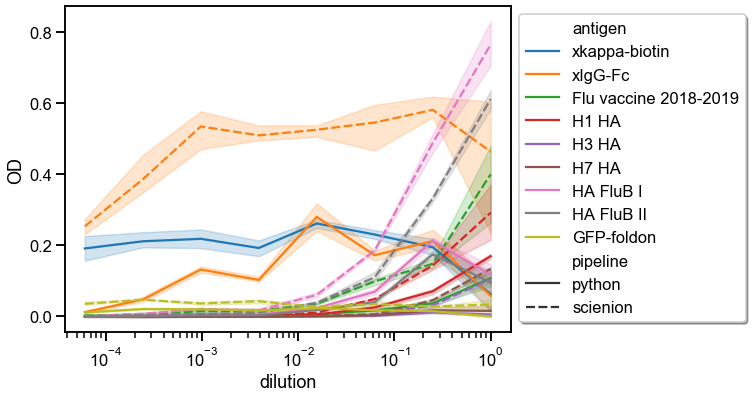

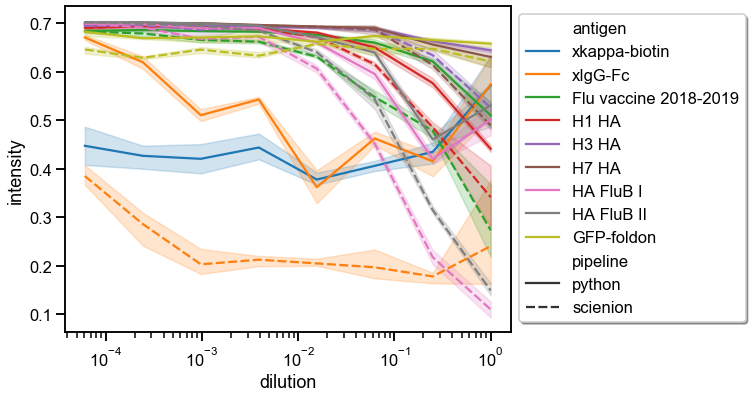

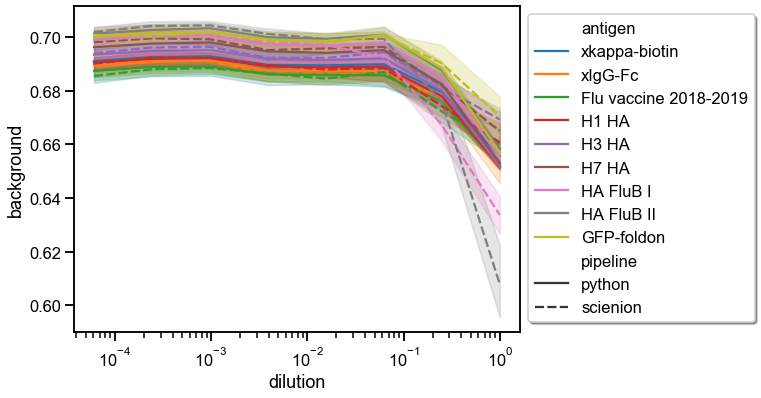

In [92]:
# serum = 'HumanReferencePlasma'
serum = 'MS'
day = 0
sub_df = canary_df[(canary_df['serum']==serum) & (canary_df['day']==day)]
y_list = ["OD", "intensity", "background"]

for y in y_list:
    plt.figure(figsize =(8, 6))
    ax1 = sns.lineplot(x="dilution", y=y, hue='antigen', style= 'pipeline', data=sub_df)
    ax1.set(xscale="log")
    lgd=ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True, ncol=1)
#     plt.savefig(os.path.join(data_folder, '.'.join([y, 'jpg'])), dpi=300, bbox_inches='tight')

In [ ]:
y_list = ["OD", "intensity", "background"]
for serum in canary_df['serum'].unique():
    serum_df = canary_df[canary_df['serum']==serum]
    for day in serum_df['day'].unique():
        day_df = serum_df[(serum_df['day']==day)]
        for y in y_list:
        #     plt.figure(figsize =(8, 6))
            g = sns.relplot(x="dilution", y=y,
                        hue="serum", col="antigen", ci='sd', style='pipeline',
                         data=day_df, col_wrap=3, estimator=np.mean, kind='line')
            g.set(xscale="log")
            plt.savefig(os.path.join(data_folder, '_'.join([serum, 'day', str(day), y + '.jpg'])), dpi=300, bbox_inches='tight')
            plt.close()

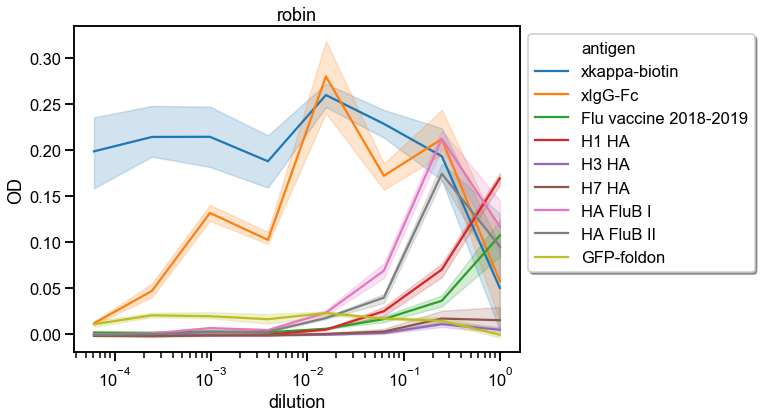

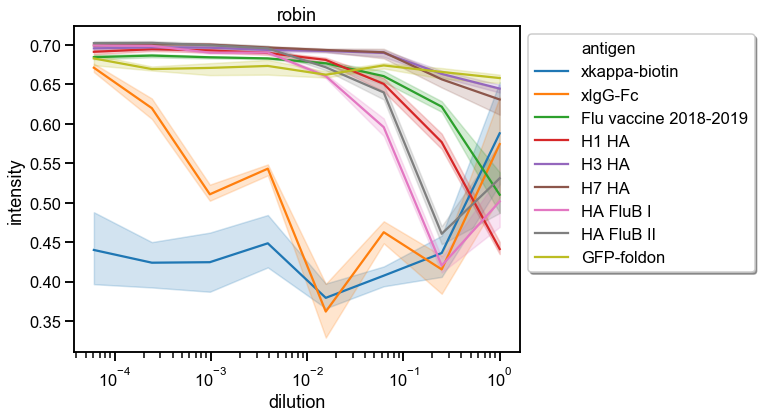

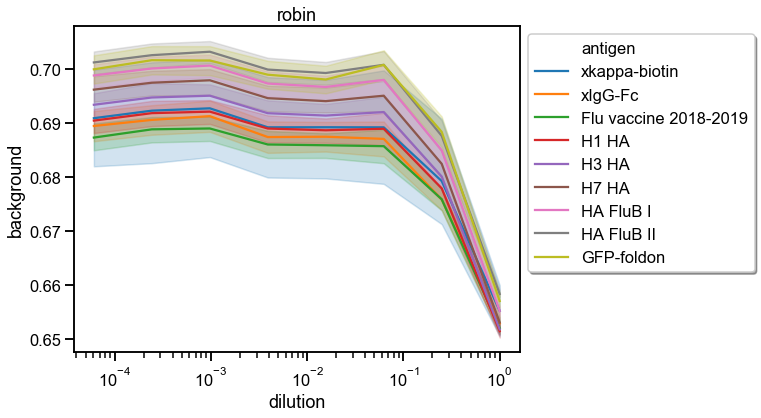

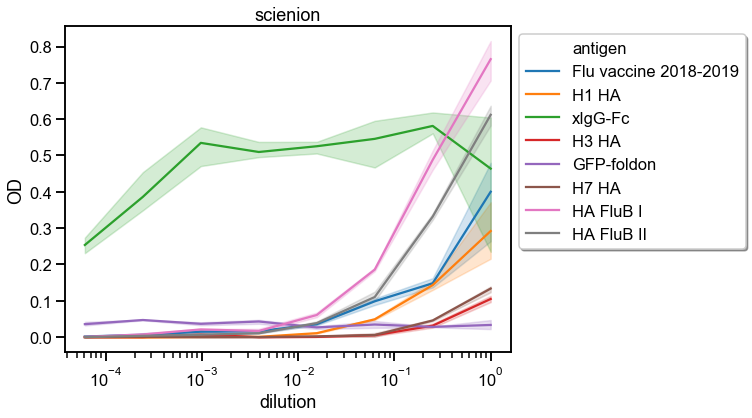

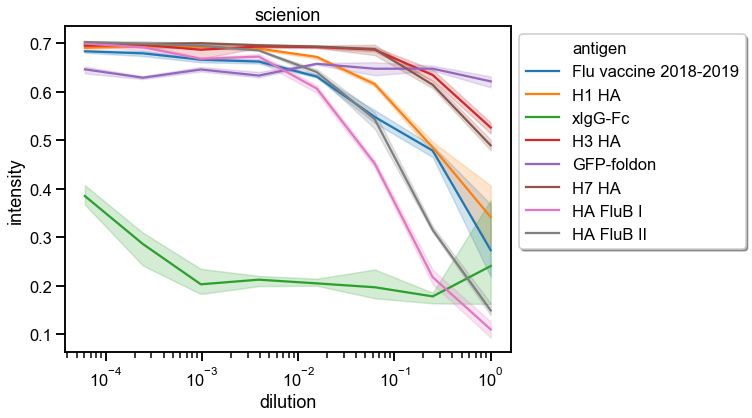

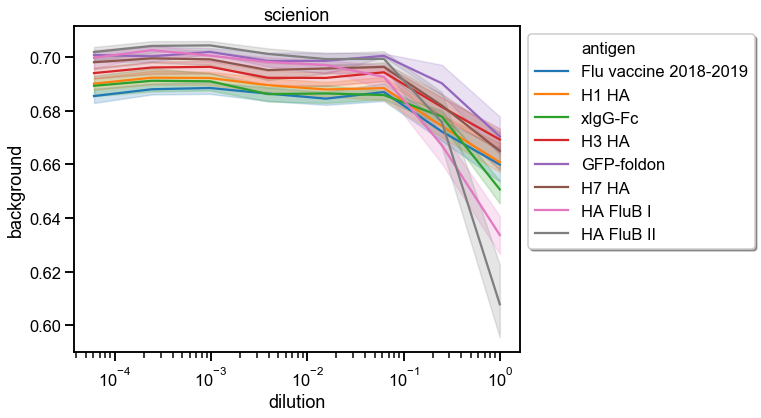

In [71]:
# serum = 'HumanReferencePlasma'
serum = 'MS'
day = 0
canary_subdf = canary_df[(canary_df['serum']==serum) & (canary_df['day']==day) & (canary_df['pipeline']=='python')]
scienion_subdf = canary_df[(canary_df['serum']==serum) & (canary_df['day']==day) & (canary_df['pipeline']=='scienion')]

y_list = ["OD", "intensity", "background"]

for y in y_list:
    fig=plt.figure(figsize =(8, 6))
    ax1 = sns.lineplot(x="dilution", y=y, hue='antigen', data=canary_subdf)
    ax1.set(xscale="log")
    plt.title('robin')
    lgd=ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True, ncol=1)
    fig.savefig(os.path.join(data_folder, y + '_robin.jpg'), dpi=300, bbox_inches='tight')

for y in y_list:
    fig=plt.figure(figsize =(8, 6))
    ax1 = sns.lineplot(x="dilution", y=y, hue='antigen', data=scienion_subdf)
    ax1.set(xscale="log")
    plt.title('scienion')
    lgd=ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True, ncol=1)
    fig.savefig(os.path.join(data_folder, y + '_scienion.jpg'), dpi=300, bbox_inches='tight')

#plt.subplot(121)
#ax1=sns.lineplot(x="dilution", y="OD", hue='antigen', data=sub_df)


In [ ]:
canary_df

# Plot standard curves

## Plot antibody response to all antigens from one serum sample

[None]

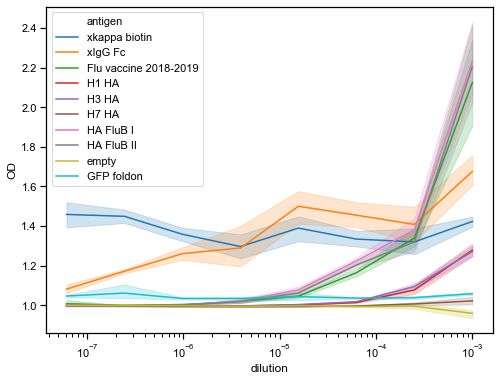

In [172]:
serum = 'HumanReferencePlasma'
sub_df = OD_df[(OD_df['serum']==serum)] 
# ref_plm_df = ref_plm_df.dropna()
plt.figure(figsize =(8, 6))
ax = sns.lineplot(x="dilution", y="OD", hue='antigen', data=sub_df)
ax.set(xscale="log")

## Compare across sera at Day 0

<Figure size 576x432 with 0 Axes>

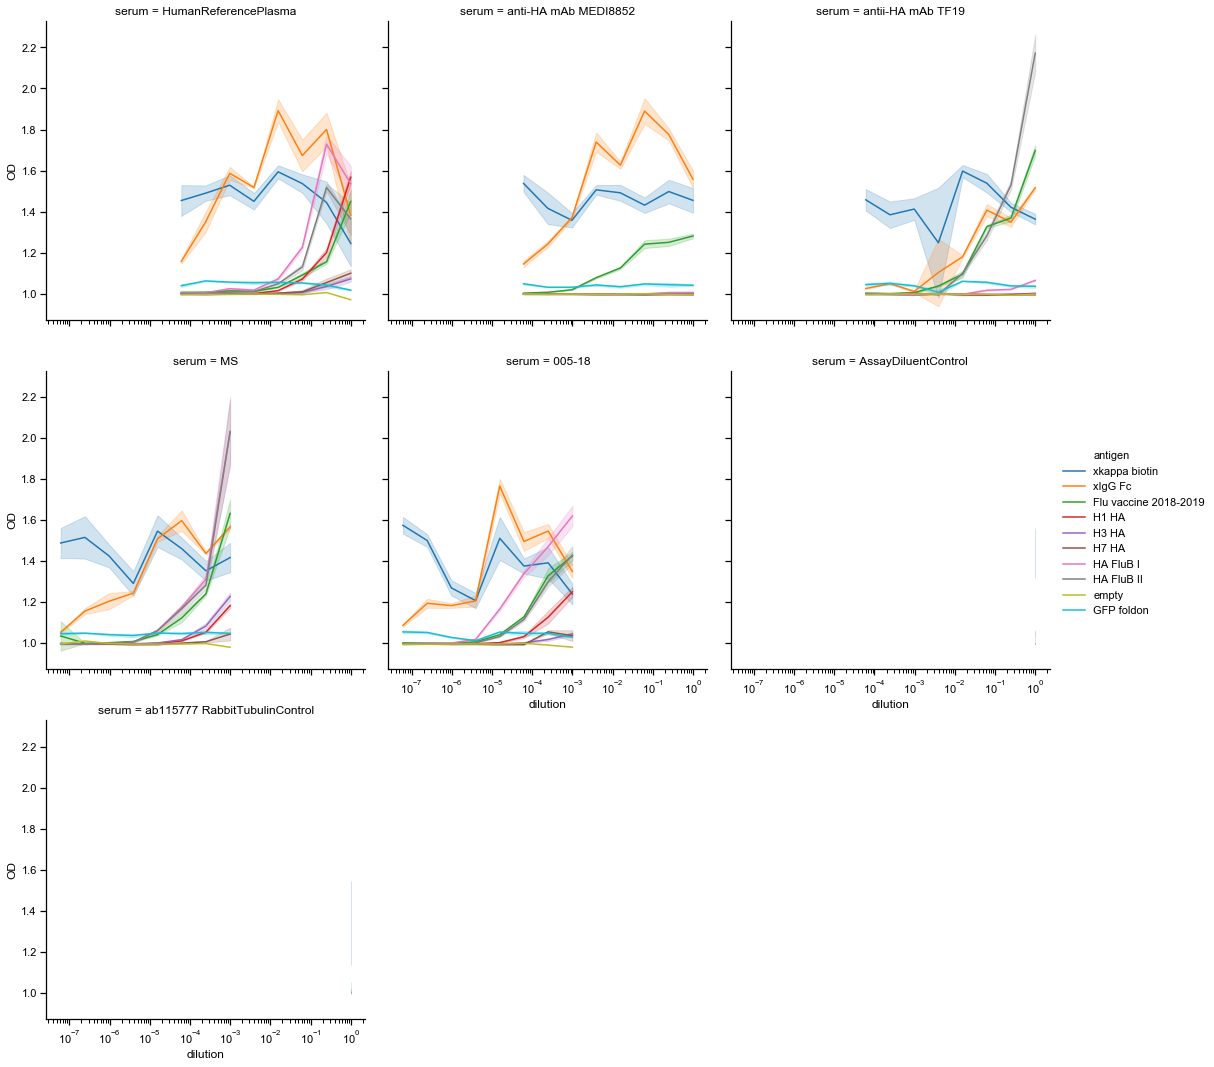

In [229]:
day = 0
sub_df = OD_df[(OD_df['day']==day)] 
plt.figure(figsize =(8, 6))
ax = sns.relplot(x="dilution", y="OD",
                hue="antigen", col="serum", 
                data=sub_df, col_wrap=3, kind='line', estimator=np.mean, ci='sd')
ax.set(xscale="log")

## Compare sera for each antigen

In [236]:
import scipy.optimize as optimization
import itertools

def fourPL(x, A, B, C, D):
    return ((A-D)/(1.0+((x/C)**(B))) + D)
   
def plot_n_fit(xdata, ydata, **kwargs):
    sns.regplot(xdata, ydata, fit_reg=False,               
             x_estimator=np.mean)
    guess = [0, 1, 1e-4, 1]
    params, params_covariance = optimization.curve_fit(fourPL, xdata, ydata, guess, bounds=(0, np.inf))#, maxfev=1)
    x_input = np.logspace(np.log10(np.min(xdata)), np.log10(np.max(xdata)), 20)
    plt.plot(x_input, fourPL(x_input, *params), label='Fitted function')

def fit2df(df, model):
    sera = df['serum'].unique()
    antigens = df['antigen'].unique()
    keys = itertools.product(sera, antigens)
    df_fit = pd.DataFrame(columns=df.columns)
    for serum, antigen in keys:
        sub_df = df[(df['serum']==serum) & (df['antigen']==antigen)]
        days = sub_df['day'].unique()
        for day in days:
            df_day_fit = pd.DataFrame(columns=df.columns)
            day_df = sub_df[(sub_df['day']==day)]
            guess = [0, 1, 1e-4, 1]
            xdata = day_df['dilution'].to_numpy()
            ydata = day_df['OD'].to_numpy()
            params, params_covariance = optimization.curve_fit(model, xdata, ydata, guess, bounds=(0, np.inf), maxfev=1e4)
            x_input = np.logspace(np.log10(np.min(xdata)), np.log10(np.max(xdata)), 20)
            y_fit = fourPL(x_input, *params)
            
            df_day_fit['dilution'] = x_input
            df_day_fit['OD'] = y_fit
            df_day_fit['serum'] = ' '.join([serum, 'fit'])
            df_day_fit['antigen'] = antigen
            df_day_fit['type'] = day_df['type'].unique()[0]
            df_day_fit['day'] = day
            df_fit = df_fit.append(df_day_fit)  
    return df_fit
OD_df_fit = fit2df(OD_df, fourPL)

HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
HumanReferencePlasma
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
anti-HA mAb MEDI8852
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
antii-HA mAb TF19
MS
MS
MS
MS
MS
MS
MS
MS
MS
MS
005-18
005-18
005-18
005-18
005-18
005-18
005-18
005-18
005-18
005-18
006
006
006
006
006
006
006
006
006
006
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
AssayDiluentControl
ab115777 RabbitTubulinControl
ab115777 RabbitTubulinControl


In [237]:
OD_df_fit

,antigen_row,antigen_col,OD,well_id,antigen,type,dilution,serum,day
0,NaN,NaN,1.453866,NaN,xkappa biotin,Control,0.000061,HumanReferencePlasma fit,0
1,NaN,NaN,1.469282,NaN,xkappa biotin,Control,0.000102,HumanReferencePlasma fit,0
2,NaN,NaN,1.469503,NaN,xkappa biotin,Control,0.000169,HumanReferencePlasma fit,0
3,NaN,NaN,1.469506,NaN,xkappa biotin,Control,0.000282,HumanReferencePlasma fit,0
4,NaN,NaN,1.469506,NaN,xkappa biotin,Control,0.000471,HumanReferencePlasma fit,0
...,...,...,...,...,...,...,...,...,...
15,NaN,NaN,1.024825,NaN,GFP foldon,Control,1.000000,ab115777 RabbitTubulinControl fit,0
16,NaN,NaN,1.024825,NaN,GFP foldon,Control,1.000000,ab115777 RabbitTubulinControl fit,0
17,NaN,NaN,1.024825,NaN,GFP foldon,Control,1.000000,ab115777 RabbitTubulinControl fit,0
18,NaN,NaN,1.024825,NaN,GFP foldon,Control,1.000000,ab115777 RabbitTubulinControl fit,0


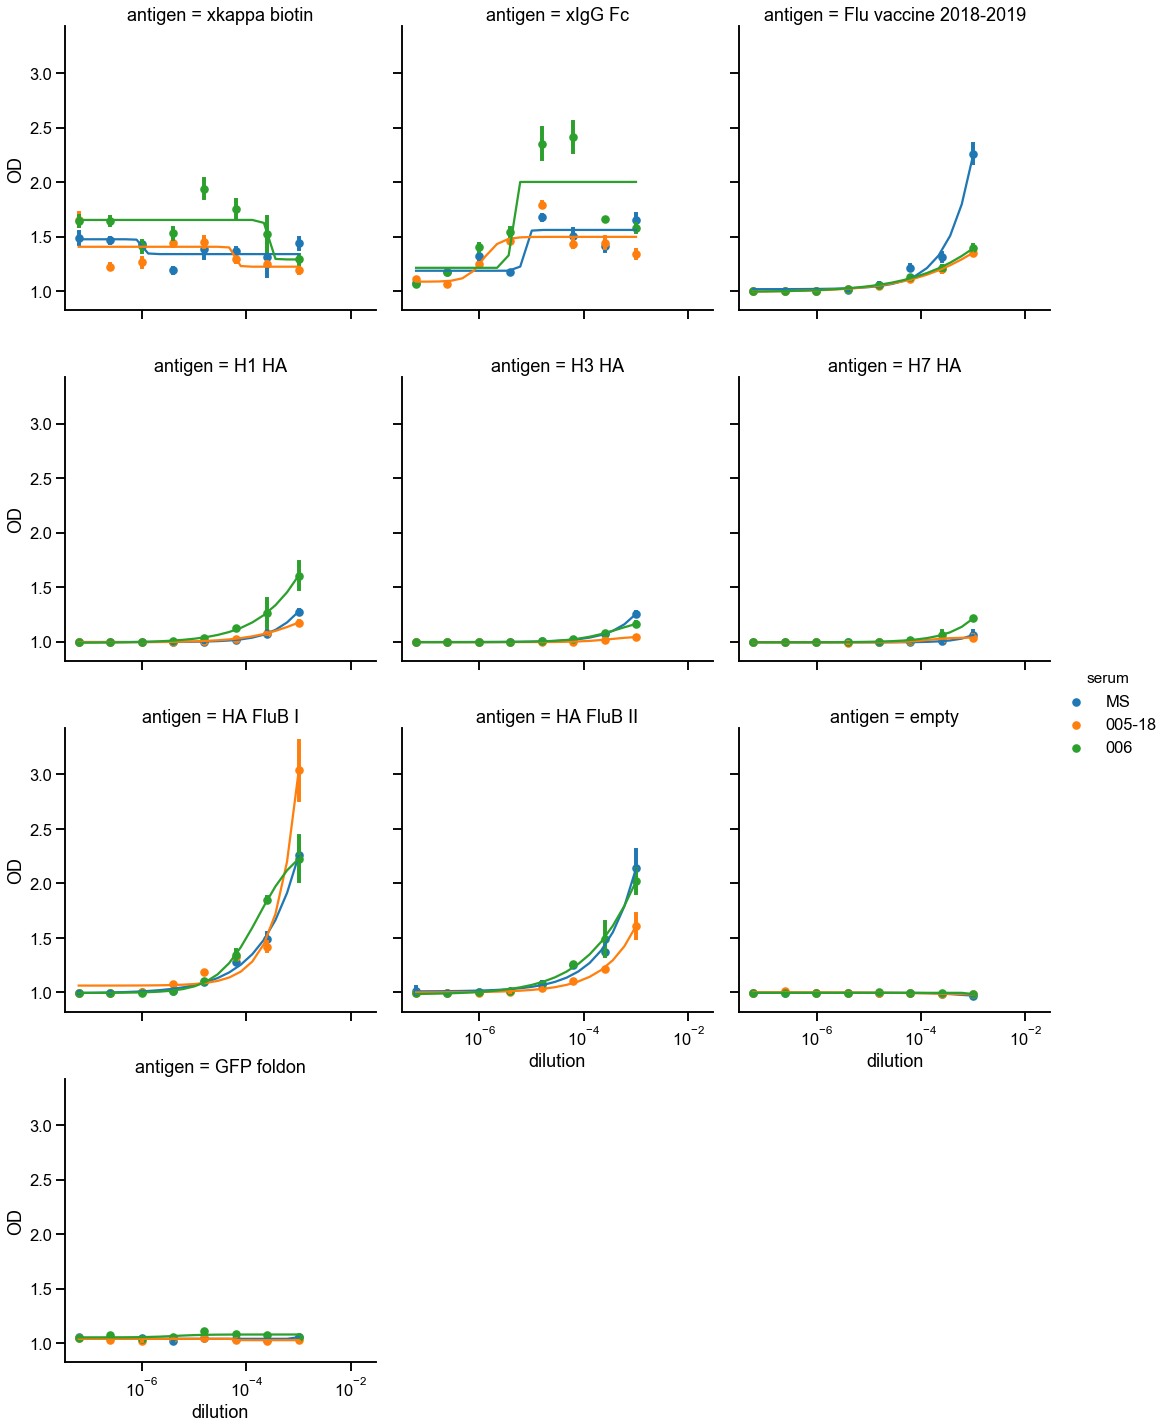

In [246]:
day = 7
serum_type = 'Diagnostic'
sub_df = OD_df[(OD_df['day']==day) & (OD_df['type']==serum_type)]

g = sns.lmplot(x="dilution", y="OD",
                hue="serum", col="antigen", ci='sd',
                 data=sub_df, col_wrap=3, fit_reg=False, x_estimator=np.mean)
sub_OD_df_fit=OD_df_fit[(OD_df_fit['day']==day) & (OD_df_fit['type']==serum_type)]

for antigen, ax in zip(sub_df['antigen'].unique(), g.axes.flat):
    df_fit = sub_OD_df_fit[sub_OD_df_fit['antigen']==antigen]
    sns.lineplot(x="dilution", y="OD", hue='serum', data=df_fit, ax=ax, legend=False)
    ax.set(xscale="log")

In [11]:
serum = 'AssayDiluentControl'
sub_df = OD_df[(OD_df['serum']==serum)]
print(sub_df['dilution'].unique())

serum = 'ab115777 RabbitTubulinControl'
sub_df = OD_df[(OD_df['serum']==serum)]
print(sub_df['dilution'].unique())

[1.]
[1.]


# Read identity of wells and antigen spots in 2D arrays if preferred

In [12]:
plateinfo_dataframe=pd.read_csv(plateinfo_path)
plateInfo=plateinfo_dataframe.to_numpy()
pprint(plateInfo)

array([['A1', 'HumanReferencePlasma', 'Control', 1.0],
       ['A2', 'anti-HA mAb MEDI8852', 'Control', 1.0],
       ['A3', 'antii-HA mAb TF19', 'Control', 1.0],
       ['A4', 'MS-Day0', 'Diagnostic', 0.001],
       ['A5', 'MS-Day7', 'Diagnostic', 0.001],
       ['A6', 'MS-Day14', 'Diagnostic', 0.001],
       ['A7', 'MS-Day21', 'Diagnostic', 0.001],
       ['A8', '005-18-Day0', 'Diagnostic', 0.001],
       ['A9', '005-18-Day7', 'Diagnostic', 0.001],
       ['A10', '005-18-Day18', 'Diagnostic', 0.001],
       ['A11', '006-Day7', 'Diagnostic', 0.001],
       ['A12', 'AssayDiluentControl', 'Control', 1.0],
       ['B1', 'HumanReferencePlasma', 'Control', 0.25],
       ['B2', 'anti-HA mAb MEDI8852', 'Control', 0.25],
       ['B3', 'antii-HA mAb TF19', 'Control', 0.25],
       ['B4', 'MS-Day0', 'Diagnostic', 0.00025],
       ['B5', 'MS-Day7', 'Diagnostic', 0.00025],
       ['B6', 'MS-Day14', 'Diagnostic', 0.00025],
       ['B7', 'MS-Day21', 'Diagnostic', 0.00025],
       ['B8', '005-18-Day0

In [13]:
converter = {col: str for col in range(0,7)}
antigens_dataframe=pd.read_excel(antigenOD_path, sheet_name='antigens', converters=converter)
antigens=antigens_dataframe.to_numpy()[:,1:] 
pprint(antigens)

array([['xkappa biotin', 'Flu vaccine 2018-2019',
        'Flu vaccine 2018-2019', 'Flu vaccine 2018-2019',
        'Flu vaccine 2018-2019', 'xkappa biotin'],
       ['xkappa biotin', 'H1 HA', 'H1 HA', 'H1 HA', 'H1 HA', 'empty'],
       ['xIgG Fc', 'H3 HA', 'H3 HA', 'H3 HA', 'H3 HA', 'GFP foldon'],
       ['xIgG Fc', 'H7 HA', 'H7 HA', 'H7 HA', 'H7 HA', 'GFP foldon'],
       ['xIgG Fc', 'HA FluB I', 'HA FluB I', 'HA FluB I', 'HA FluB I',
        'GFP foldon'],
       ['xkappa biotin', 'HA FluB II', 'HA FluB II', 'HA FluB II',
        'HA FluB II', 'xkappa biotin']], dtype=object)


# Read ODs of all wells in a 4D array (Well row x Well column x Array row x Array column)

## Read data

In [14]:
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
antigenOD=np.empty((8,12,6,6)) # 96 wells, 6 antigen rows, 8 antigen columns
wellID=np.empty((8,12),dtype=object)

In [15]:
# Read all wells into dictionary and into a 4D numpy array.
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        antigenOD_dataframe=pd.read_excel(antigenOD_path, sheet_name=well_key)
        antigenOD[r,c,:,:]=antigenOD_dataframe.to_numpy()[:,1:] # First column is simply the index. to_numpy returns 6x9 array.
        wellID[r,c] = well_key

## how to index the OD data.

#### direct indexing

In [16]:
pprint(antigenOD[0,0]) # Well A1

array([[1.36503811, 1.5155178 , 1.45785232, 1.44306173, 1.38163254,
        1.3063261 ],
       [1.30002172, 1.61077511, 1.56254699, 1.53840071, 1.55704935,
        0.97001301],
       [1.52734561, 1.08392779, 1.08187972, 1.06285456, 1.05726947,
        1.01487095],
       [1.38300153, 1.1188896 , 1.08965004, 1.07749847, 1.11146203,
        1.01577171],
       [1.23516534, 1.61545466, 1.48470893, 1.440994  , 1.60285462,
        1.01984698],
       [1.11721243, 1.44748857, 1.26443018, 1.3972606 , 1.34868749,
        1.13418449]])


In [17]:
pprint(antigenOD[0,3]) # well A4

array([[1.51057438, 1.72730503, 1.60149197, 1.63297109, 1.5686067 ,
        1.32212619],
       [1.39139012, 1.19648487, 1.17148837, 1.17381992, 1.1895725 ,
        0.9799163 ],
       [1.55854897, 1.24260422, 1.21974564, 1.20463072, 1.24338333,
        1.04502998],
       [1.56578046, 1.08637737, 1.04226942, 1.03899924, 1.01072581,
        1.05024331],
       [1.57689151, 2.25824464, 1.95320697, 1.86113774, 2.05701918,
        1.04949529],
       [1.46018973, 2.25584258, 1.96541285, 1.9000124 , 2.00442124,
        1.40289936]])


#### logical indexing

In [18]:
pprint(antigenOD[wellID == 'A4'])

array([[[1.51057438, 1.72730503, 1.60149197, 1.63297109, 1.5686067 ,
         1.32212619],
        [1.39139012, 1.19648487, 1.17148837, 1.17381992, 1.1895725 ,
         0.9799163 ],
        [1.55854897, 1.24260422, 1.21974564, 1.20463072, 1.24338333,
         1.04502998],
        [1.56578046, 1.08637737, 1.04226942, 1.03899924, 1.01072581,
         1.05024331],
        [1.57689151, 2.25824464, 1.95320697, 1.86113774, 2.05701918,
         1.04949529],
        [1.46018973, 2.25584258, 1.96541285, 1.9000124 , 2.00442124,
         1.40289936]]])


In [19]:
pprint(antigenOD[wellID == 'A1'])

array([[[1.36503811, 1.5155178 , 1.45785232, 1.44306173, 1.38163254,
         1.3063261 ],
        [1.30002172, 1.61077511, 1.56254699, 1.53840071, 1.55704935,
         0.97001301],
        [1.52734561, 1.08392779, 1.08187972, 1.06285456, 1.05726947,
         1.01487095],
        [1.38300153, 1.1188896 , 1.08965004, 1.07749847, 1.11146203,
         1.01577171],
        [1.23516534, 1.61545466, 1.48470893, 1.440994  , 1.60285462,
         1.01984698],
        [1.11721243, 1.44748857, 1.26443018, 1.3972606 , 1.34868749,
         1.13418449]]])


# Plot standard curve.

In [20]:
# Prepare arrays for logical indexing.
# Logical indexing works only for numpy array only not the standard python lists.

wellIdx = np.array([row+str(col) for row in ['A','B','C','D','E','F','G','H'] for col in range(1,13)])
wellmetaIdx=np.array(['Well','SeraID','Type','Concentration'])
antigenIdx = antigens.flatten()

# Transform antigenODs to wellxspot structure.
ODwellbyantigen=antigenOD.reshape(len(wellIdx),len(antigenIdx))
#pprint(wellIdx)
#pprint(antigenIdx)

## Find concentrations in control wells

#The control wells in this plate are in columns. A2-H2 is an anti-HA antibody against spots in the top spot row, A3-H3 is an anti-HA antibody against spots in the top spot row and bottom spot row. Column 12 of the plate contains an assay diluent control.

In [21]:
controlWells = []
for row in ['A','B','C','D','E','F','G','H']:
    wellsinthisrow = [row+str(col) for col in range(2,4)]
    controlWells.append(wellsinthisrow)
pprint(controlWells)

[['A2', 'A3'],
 ['B2', 'B3'],
 ['C2', 'C3'],
 ['D2', 'D3'],
 ['E2', 'E3'],
 ['F2', 'F3'],
 ['G2', 'G3'],
 ['H2', 'H3']]


In [24]:
controlWells = np.reshape(controlWells,(16,))
controlConcentrations=np.concatenate([plateInfo[wellIdx == well, wellmetaIdx == 'Concentration'] for well in controlWells])
pprint(controlConcentrations)

array([1.0, 1.0, 0.25, 0.25, 0.0625, 0.0625, 0.015625, 0.015625,
       0.00390625, 0.00390625, 0.000976563, 0.000976563,
       0.00024414099999999997, 0.00024414099999999997, 6.1e-05, 6.1e-05],
      dtype=object)


In [25]:

concentrationsAll = np.array([float(strconc) for strconc in controlConcentrations])
concentrations=concentrationsAll[1::2]
pprint(concentrations)

array([1.00000e+00, 2.50000e-01, 6.25000e-02, 1.56250e-02, 3.90625e-03,
       9.76563e-04, 2.44141e-04, 6.10000e-05])


In [26]:
controlWellsMEDI=controlWells[0::2]
pprint(controlWellsMEDI)

array(['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2'], dtype='<U2')


## Let's look at mAb MEDI8852 against spot 'Flu vaccine 2018-2019' in the control wells.

In [27]:
antigenvaccine=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in controlWellsMEDI])
pprint(antigenvaccine)

array([[1.29361701, 1.28230958, 1.26620668, 1.28148715],
       [1.22413749, 1.25108522, 1.26219094, 1.26221479],
       [1.23226354, 1.21985598, 1.24805682, 1.26364718],
       [1.1328589 , 1.12572158, 1.11748446, 1.12382501],
       [1.07654113, 1.07959817, 1.08066351, 1.07320915],
       [1.01554702, 1.02020619, 1.01955793, 1.01968565],
       [1.00726404, 1.00590698, 1.00645212, 1.00599513],
       [1.00224073, 1.00265987, 1.00239297, 1.00151115]])


In [28]:
#antigenvaccine=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in controlWellsMEDI])

#plt.figure(figsize=(10,10))
#plt.plot(concentrations,antigenvaccine,concentrations,np.mean(antigenvaccine,axis=1),lw=4 );
#plt.legend(['spot-1-2','spot-1-3','spot-1-4','spot-1-5','mean'])
#plt.title('anti-HA mAb MEDI8852 to Flu vaccine 2018-2019');


## Fit a 4PL to mean values from anti-HA mAB MEDI8852 to vaccine spots

#To generate a curve, arrange a np array of standard curve concentrations in ascending order, and arrays of ODs from standard curve and unknown samples in increasing concentration (i.e. highest dilution at first element of array)

In [29]:
concentrations2=[300,
75,
18.75,
4.6875,
1.171875,
0.29296875,
0.073242188,
0.018310547]
concentrations2=np.flip(concentrations2)
pprint(concentrations2)

array([1.8310547e-02, 7.3242188e-02, 2.9296875e-01, 1.1718750e+00,
       4.6875000e+00, 1.8750000e+01, 7.5000000e+01, 3.0000000e+02])


In [30]:
flippedmeans=np.flip(np.mean(antigenvaccine,axis=1)) #flip the mean values to be in increasing order

#In the following cell, input xdata as array of concentrations and ydata as array of ODs for standard curve. Adjust labels and title on plot. 

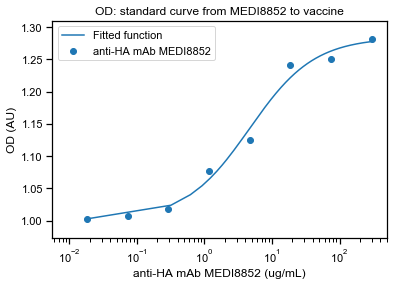

In [51]:
import scipy.optimize as optimization
xdata = concentrations2
ydata = flippedmeans
def fourPL(x, A, B, C, D):
    return ((A-D)/(1.0+((x/C)**(B))) + D)

guess = [0, 0.5, 0.5, 1]
params, params_covariance = optimization.curve_fit(fourPL, xdata, ydata, guess, bounds=(0, np.inf))#, maxfev=1)

x_min, x_max = np.amin(xdata), np.amax(xdata)
xs = np.linspace(x_min, x_max, 1000)
ax = plt.scatter(xdata, ydata, label='anti-HA mAb MEDI8852')
plt.plot(xs, fourPL(xs, *params), label='Fitted function')
plt.xscale("log")
plt.legend(loc='best')
plt.xlabel('anti-HA mAb MEDI8852 (ug/mL)')
plt.ylabel('OD (AU)')
plt.title('OD: standard curve from MEDI8852 to vaccine');
plt.show()

#The concentration of MEDI8852 starts at 300 ug/mL (or 10x), so we can add that to the plot for interpolation

In [44]:
pprint(params) #These are the parameters for the 4PL

array([1.00088831, 0.90685777, 4.62797342, 1.28376892])


In [33]:
def getConcentration(ODs,params):
    A=[params[0]]
    A=np.asarray(A)
    B=[params[1]]
    B=np.asarray(B)
    C=[params[2]]
    C=np.asarray(C)
    D=[params[3]]
    D=np.asarray(D)
# I think there is an issue with raising negative numbers to a fractional exponent. This needs to be fixed
    #return C*((((A-D)/(ODs-D))-1) **(1/B))
    return C*(((np.sign(((A-D)/(ODs-D))-1))*(np.abs(((A-D)/(ODs-D))-1)))**(1/B))

In [34]:
test60=np.array([1,0.99,1.632,1.24])
test61=getConcentration(test60,params)
pprint(test61)

array([        nan,         nan,         nan, 30.10002861])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':


In [135]:
#All dilutions for each day
Day0=['A4','B4','C4','D4','E4','F4','G4','H4']
Day7=['A5','B5','C5','D5','E5','F5','G5','H5']
Day14=['A6','B6','C6','D6','E6','F6','G6','H6']
Day21=['A7','B7','C7','D7','E7','F7','G7','H7']


# Generate a stack of all ODs for an MS antibody response per antigen on Day0 
FluVaccineMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day0])
H1HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H1 HA'] for well in Day0])
H3HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H3 HA'] for well in Day0])
H7HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H7 HA'] for well in Day0])
HAFluBIMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB I'] for well in Day0])
HAFluBIIMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB II'] for well in Day0])

# Generate means per well
mFluVaccineMSDay0=np.mean(FluVaccineMSDay0,axis=1) # average within each well.
mH1HAMSDay0=np.mean(H1HAMSDay0,axis=1)
mH3HAMSDay0=np.mean(H3HAMSDay0,axis=1)
mH7HAMSDay0=np.mean(H7HAMSDay0,axis=1)
mHAFluBIMSDay0=np.mean(HAFluBIMSDay0,axis=1)
mHAFluBIIMSDay0=np.mean(HAFluBIMSDay0,axis=1)

allMeans=[mFluVaccineMSDay0,mH1HAMSDay0, mH3HAMSDay0,mH7HAMSDay0,mHAFluBIMSDay0,mHAFluBIIMSDay0]

allMeans = np.asarray(allMeans)

allConcentrations=getConcentration(allMeans,params)
pprint(allMeans)
pprint(allConcentrations)

array([[1.6325937 , 1.24057201, 1.12274793, 1.04168365, 1.00825405,
        1.0023307 , 0.99973903, 1.03495   ],
       [1.18284141, 1.05365641, 1.01095905, 0.99956109, 0.99464464,
        0.99662646, 0.99682175, 0.99788761],
       [1.22759098, 1.08346679, 1.01743137, 1.00075848, 0.99729104,
        0.99765584, 0.99699758, 0.99808423],
       [1.04459296, 1.00691867, 1.00022285, 0.99342826, 0.99325535,
        0.99510629, 0.9959808 , 0.99560323],
       [2.03240213, 1.31247131, 1.17488615, 1.06124772, 1.00449509,
        0.99815258, 0.99566044, 0.99736447],
       [2.03240213, 1.31247131, 1.17488615, 1.06124772, 1.00449509,
        0.99815258, 0.99566044, 0.99736447]])
array([[           nan, 3.06204191e+01, 3.40359700e+00, 6.49534761e-01,
        8.52921127e-02, 1.37992645e-02,            nan, 5.16502649e-01],
       [8.86398656e+00, 9.12289699e-01, 1.21739347e-01,            nan,
                   nan,            nan,            nan,            nan],
       [2.15532111e+01, 1.74199

<ipython-input-133-ca68501019d1>:12: RuntimeWarning: invalid value encountered in power
  return C*(((np.sign(((A-D)/(ODs-D))-1))*(np.abs(((A-D)/(ODs-D))-1)))**(1/B))


## Multiply by dilution factor to get the corrected concentration values

In [114]:
initialConcentration=allConcentrations[:,0] #All antigens at the initial concentration for Day 0 from MS serum
correctedConcentration=initialConcentration*1000 #in ug/mL
pprint(correctedConcentration) #in ug/mL


array([           nan,  8863.98656432, 21553.21107321,   710.20283383,
                  nan,            nan])


In [115]:
correctedConcentrationResult = {'Flu vaccine 2018-2019':[correctedConcentration[0]],'H1 HA':[correctedConcentration[1]], 'H3 HA':[correctedConcentration[2]],'H7 HA':[correctedConcentration[3]] ,'HA FluB I':[correctedConcentration[4]], 'HA FluB II':[correctedConcentration[5]]}
pprint(correctedConcentrationResult)
#df = pd.DataFrame(data=correctedConcentrationResult)

{'Flu vaccine 2018-2019': [nan],
 'H1 HA': [8863.986564317329],
 'H3 HA': [21553.211073212395],
 'H7 HA': [710.2028338295794],
 'HA FluB I': [nan],
 'HA FluB II': [nan]}
